<a href="https://colab.research.google.com/github/RajaduraiThamizhmani/Classifying-the-Iris-Data-Set-with-Keras/blob/main/Classifying_IRIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Data Preperation

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
# Importing the dataset
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

The OneHotEncoder to encode the integer features into a One-hot vector and we will use a StandardScaler to remove the mean and scale the features to unit variance.

In [ ]:
# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

In [ ]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5, random_state=2)

In [ ]:
n_features = X.shape[1]
n_classes = Y.shape[1]

# Visualize the Data

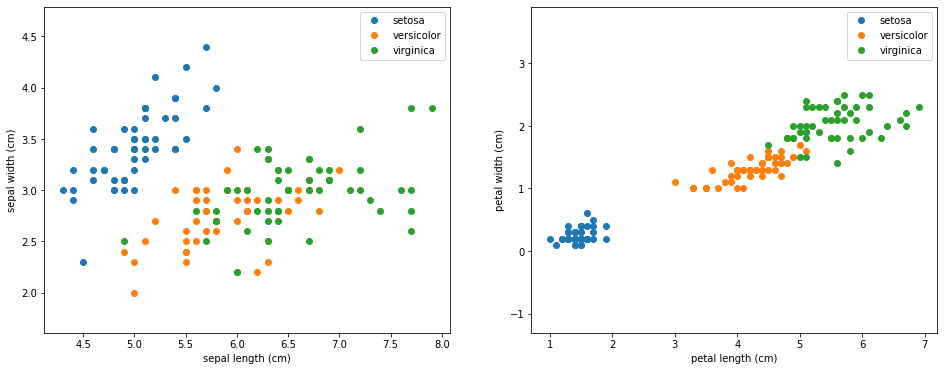

In [ ]:
# Visualize the data sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

# Making a ANN classifier
Comparing networks with the regular Dense layer with different number of nodes and we will employ a Softmax activation function and the Adam optimizer.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

def create_custom_model(input_dim, output_dim, nodes, n=1, name='model'):
    def create_model():
        # Create model
        model = Sequential(name=name)
        for i in range(n):
            model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
        model.add(Dense(output_dim, activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
        return model
    return create_model

models = [create_custom_model(n_features, n_classes, 8, i, 'model_{}'.format(i)) 
          for i in range(1, 4)]

for create_model in models:
    create_model().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 27        
Total params: 139
Trainable params: 139
Non-tr

# Making the prediciton and Evaluating the model

In [ ]:
from keras.callbacks import TensorBoard

history_dict = {}

# TensorBoard Callback
cb = TensorBoard()

for create_model in models:
    model = create_model()
    print('Model name:', model.name)
    history_callback = model.fit(X_train, Y_train,
                                 batch_size=5,
                                 epochs=50,
                                 verbose=0,
                                 validation_data=(X_test, Y_test),
                                 callbacks=[cb])
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    history_dict[model.name] = [history_callback, model]

Model name: model_1
Test loss: 0.2462940216064453
Test accuracy: 0.9333333373069763
Model name: model_2
Test loss: 0.1966187059879303
Test accuracy: 0.9333333373069763
Model name: model_3
Test loss: 0.11905121058225632
Test accuracy: 0.9599999785423279


# Plot Accuracy and Loss from Training

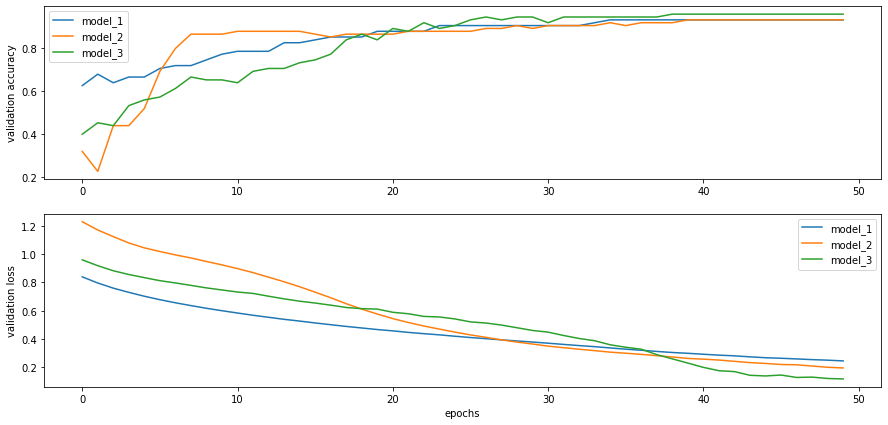

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 7))

for model_name in history_dict:
    val_accurady = history_dict[model_name][0].history['val_accuracy']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(val_accurady, label=model_name)
    ax2.plot(val_loss, label=model_name)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend();

We can clearly see that adding more nodes makes the training perform better.

# Show ROC curve
we can compare now with the Receiver Operating Characteristic (ROC) how well the models perform.

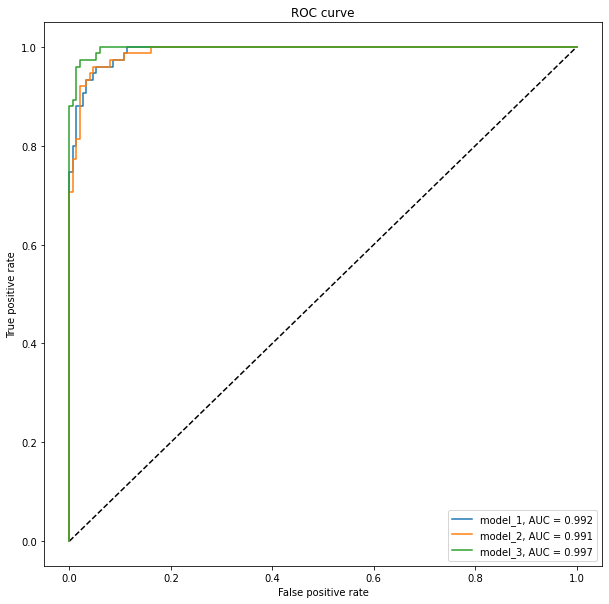

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

for model_name in history_dict:
    model = history_dict[model_name][1]
    
    Y_pred = model.predict(X_test)
    fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())
    
    plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format(model_name, auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

The ROC plot compares the false positive rate with the true positive rate. We additionally compute for each model the Area under the curve (AUC), where auc = 1 is perfect classification and auc = 0.5 is random guessing (for a two class problem).

# Measuring Performance with Cross Validation
Finally, we measure performance with 10-fold cross validation for the model_3 by using the KerasClassifier.

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

create_model = create_custom_model(n_features, n_classes, 8, 3)

estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=5, verbose=0)
scores = cross_val_score(estimator, X_scaled, Y, cv=10)
print("Accuracy : {:0.2f} (+/- {:0.2f})".format(scores.mean(), scores.std()))


Accuracy : 0.93 (+/- 0.08)
